In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install phik
!pip install eli5
!pip install catboost
!pip install shap
!pip install umap
!pip install umap-learn

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('dark_background')

### Загружаем и знакомимся

In [8]:
path = '/content/drive/MyDrive/Colab Notebooks/ВСК Страхование/Задание (пролонгация).xlsx'
xl = pd.ExcelFile(path)
xl.sheet_names

['Переменные', 'data_full']

In [9]:
description = pd.read_excel(path, sheet_name='Переменные', index_col='id')
description

,ID договора
id,
Filial,Филиал продажи
Type_ts,Тип ТС
passport_region,Регион по серии паспорта
VIP,VIP клиент
Brand,Марка ТС
Model,Модель ТС
Yr_production,Год выпуска ТС
GAP,GAP застрахован
married,Брак


In [10]:
df = pd.read_excel(path, sheet_name='data_full', index_col='ID')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10863 entries, 1 to 10863
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Filial           10863 non-null  object 
 1   Type_ts          10863 non-null  object 
 2   passport_region  10863 non-null  object 
 3   VIP              284 non-null    object 
 4   Brand            10863 non-null  object 
 5   Model            10863 non-null  object 
 6   Yr_production    10863 non-null  int64  
 7   GAP              10863 non-null  object 
 8   married          10863 non-null  object 
 9   KBM              10863 non-null  int64  
 10  KBM_prol_est     10863 non-null  int64  
 11  delta_kbm        10863 non-null  int64  
 12  deduct           10863 non-null  object 
 13  deduct_amount    10863 non-null  object 
 14  product          10863 non-null  object 
 15  Bank             10863 non-null  object 
 16  channel - map    10863 non-null  object 
 17  category    

In [12]:
# Количество значений в разных категориях
pd.DataFrame(df.nunique(), columns = ['Количество']).T

,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,KBM,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
Количество,22,2,85,2,23,200,10,2,2,13,...,67,57,5,16,3,2,13,21,2,3


In [13]:
df['VIP'].value_counts(dropna=False)

NaN                10579
Особый статус +      201
Особый статус         83
Name: VIP, dtype: int64

In [14]:
df.drop_duplicates(inplace=True)

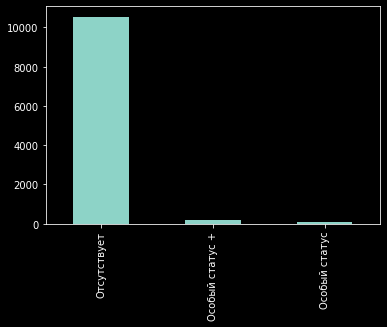

In [15]:
df['VIP'].fillna('Отсутствует', inplace=True)
df['VIP'].value_counts().plot(kind='bar');

In [16]:
train = df[df['target'] != -1].copy()

In [17]:
train.select_dtypes(np.number)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
ID,,,,,,,,,,,,,
1,2018,8,6,-2,42,24,1.00,1400000,0,55000,0.040,0,0
2,2016,8,6,-2,41,4,1.05,200000,0,10000,0.010,0,0
3,2018,8,6,-2,49,20,0.95,400000,0,30000,0.065,1,1
4,2016,8,6,-2,40,15,1.10,400000,0,10000,0.020,1,0
5,2018,8,6,-2,58,23,1.00,400000,0,10000,0.015,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7594,2018,8,6,-2,40,10,1.00,600000,0,10000,0.010,0,0
7595,2018,8,6,-2,37,16,1.00,1000000,0,15000,0.010,0,0
7596,2018,8,6,-2,44,20,0.90,800000,0,45000,0.045,0,0


In [18]:
train.select_dtypes(object)

,Filial,Type_ts,passport_region,VIP,Brand,Model,GAP,married,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,sex
ID,,,,,,,,,,,,,,,,
1,Магнитогорский,Иностранные,Челябинская область,Отсутствует,TOYOTA,RAV 4,Нет,Состоит в браке,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M
2,Магнитогорский,Отечественные,Челябинская область,Отсутствует,LADA,GRANTA,Нет,Состоит в браке,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,M
3,Ростовский,Отечественные,Ростовская область,Отсутствует,LADA,GRANTA,Нет,Не состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,F
4,Казанский,Иностранные,Республика Татарстан,Отсутствует,KIA,RIO,Нет,Не состоит в браке,Без франшизы,0,Компакт,Сетелем,Автосалоны,RN,Водители согласно перечню,M
5,Московский,Иностранные,Москва,Отсутствует,DATSUN,ON-DO,Нет,Состоит в браке,Без франшизы,0,Компакт,Без банка,Розница,NB 0-1,Водители согласно перечню,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7594,Санкт - Петербургский,Отечественные,Ленинградская область,Отсутствует,LADA,LARGUS,Нет,Состоит в браке,Без франшизы,0,Компакт,Без банка,Автосалоны,NB 0-1,Водители согласно перечню,M
7595,Московский,Иностранные,Московская область,Отсутствует,HYUNDAI,CRETA,Нет,Состоит в браке,Безусловная франшиза,20000+,Классика,Сетелем,Автосалоны,NB 0-1,Водители согласно перечню,F
7596,Санкт - Петербургский,Иностранные,Санкт-Петербург,Отсутствует,RENAULT,DUSTER,Нет,Не состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M


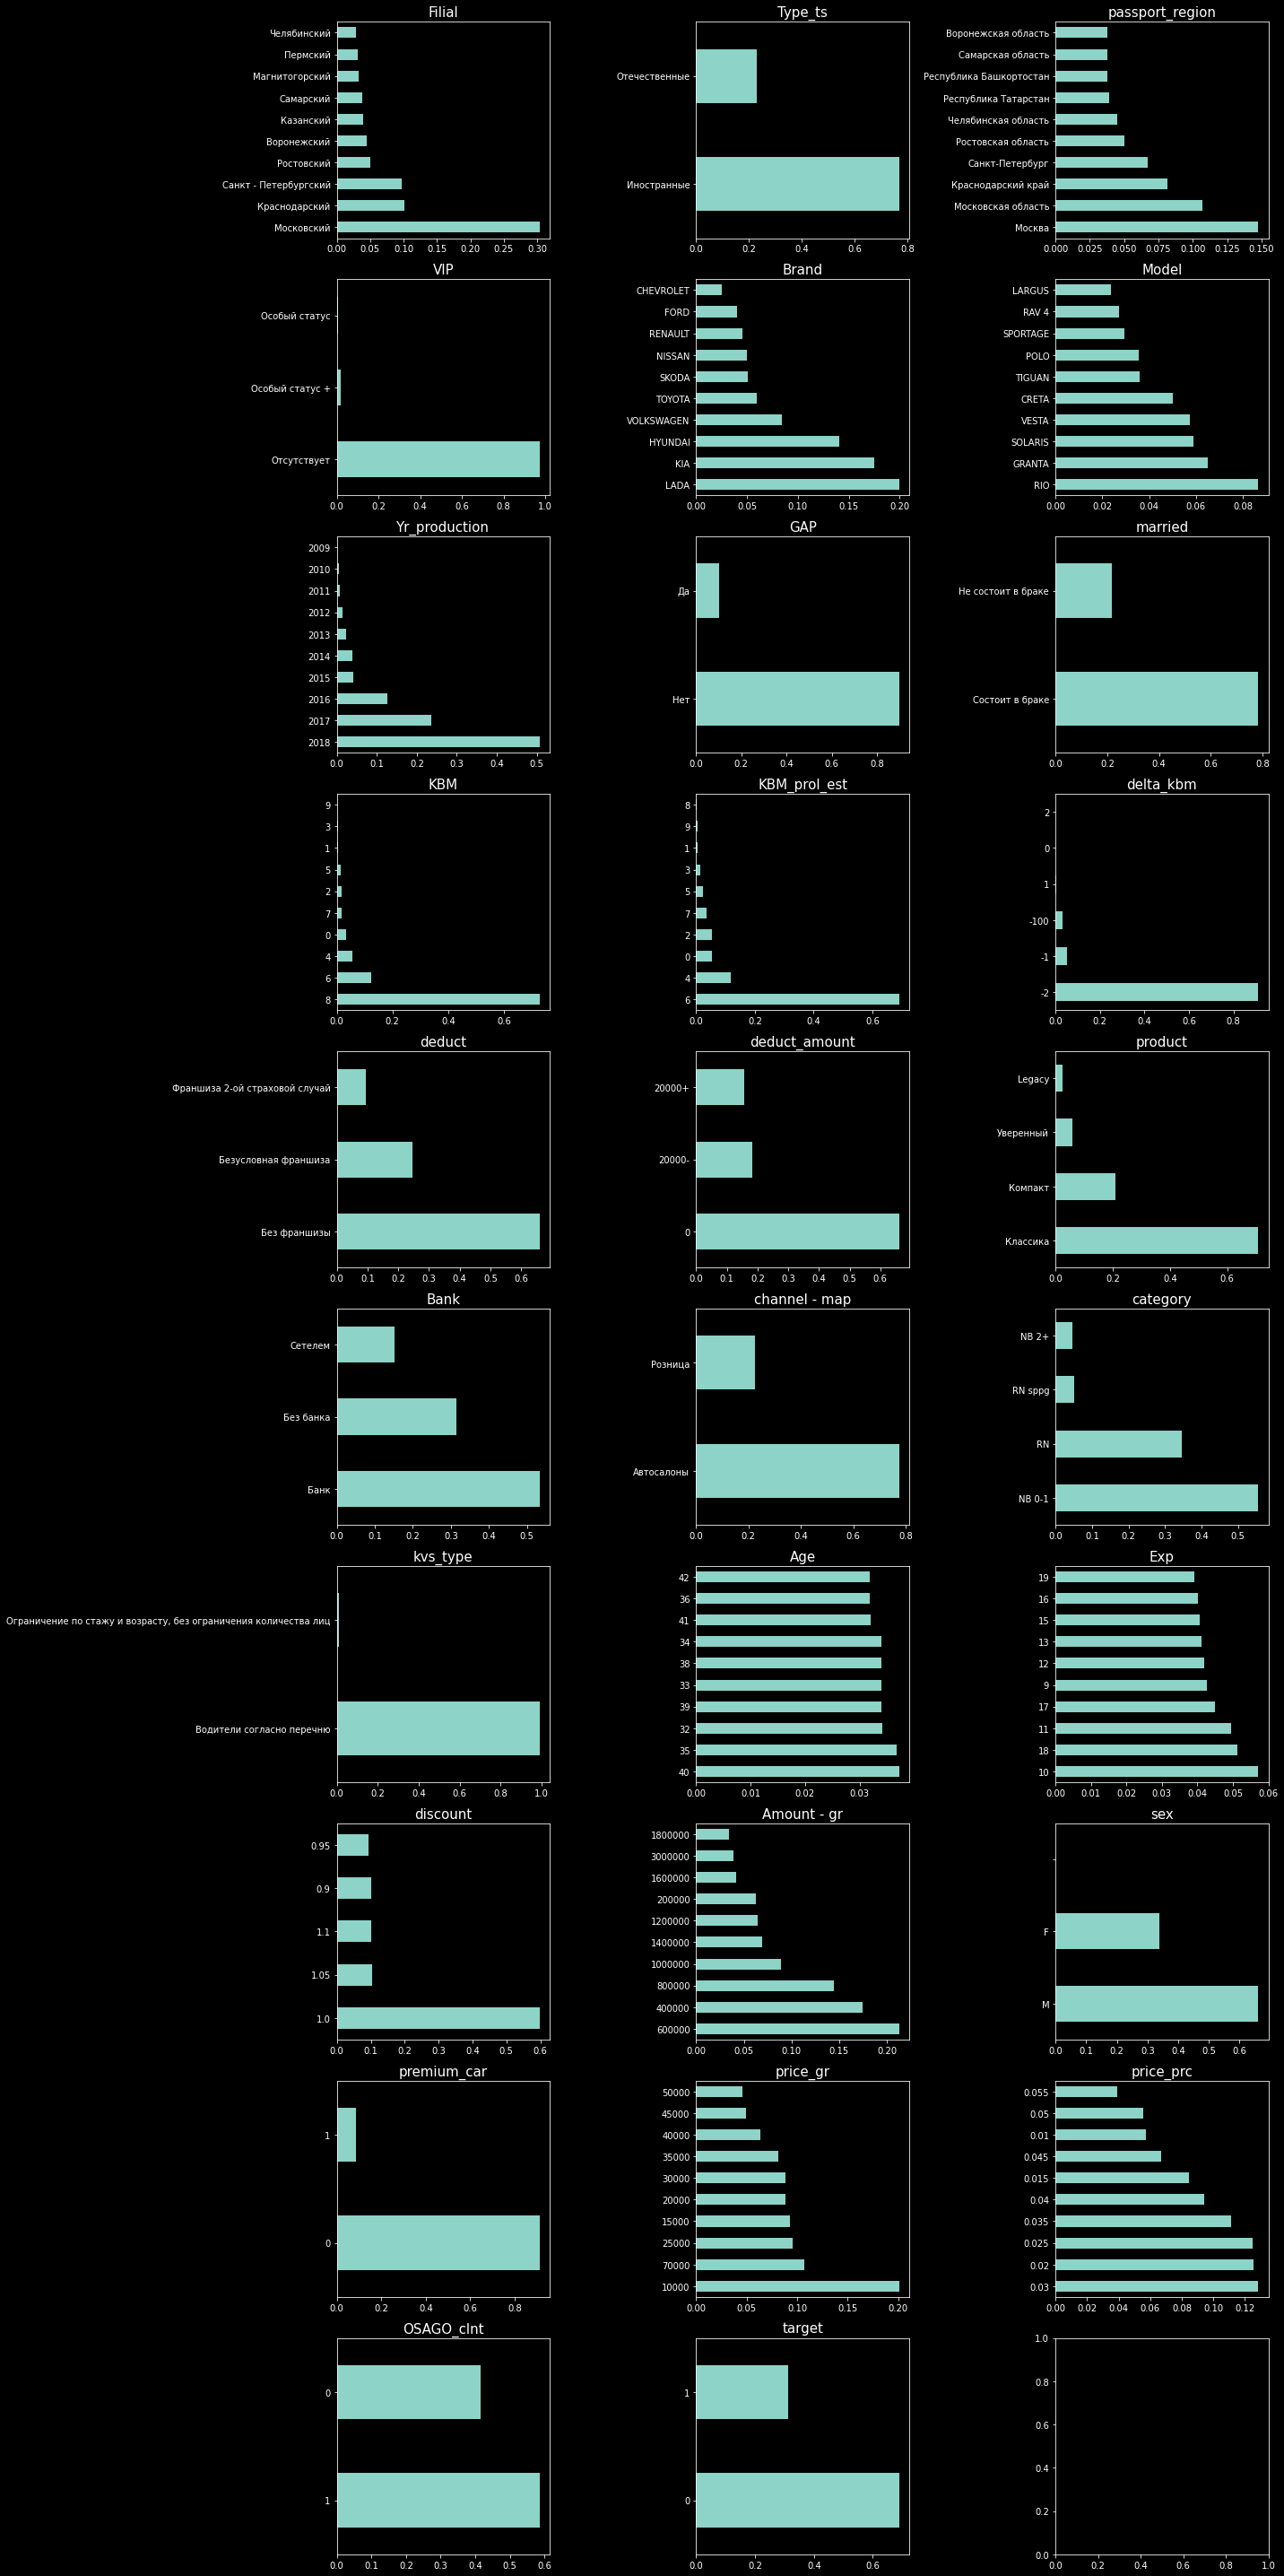

In [19]:
n=3
name_columns = train.columns.to_list()
count_columns = len(name_columns)
row = round(count_columns/n)

fig, axes = plt.subplots(row, n, figsize=(20, 40))
ax = axes.ravel()

for i, c in enumerate(name_columns):
    train[c].value_counts(normalize=True).head(10).plot(kind='barh', ax=ax[i], fontsize=10)
    ax[i].set_title(c, fontsize = 15)

plt.tight_layout()
plt.show();

In [20]:
train.describe()

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
count,7576.00000,7576.000000,7576.000000,7576.000000,7576.000000,7576.000000,7576.000000,7.576000e+03,7576.000000,7576.000000,7576.000000,7576.000000,7576.000000
mean,2016.93717,7.054382,5.187038,-5.074842,43.743136,17.228089,1.000568,9.776663e+05,0.087909,32731.652587,0.033213,0.585929,0.311246
std,1.55073,1.923610,1.731173,17.284040,11.313266,9.659168,0.050322,6.804601e+05,0.283181,19729.000449,0.016926,0.492593,0.463034
min,2009.00000,0.000000,0.000000,-100.000000,18.000000,0.000000,0.900000,0.000000e+00,0.000000,10000.000000,0.000000,0.000000,0.000000
25%,2016.00000,6.000000,5.000000,-2.000000,35.000000,10.000000,1.000000,6.000000e+05,0.000000,15000.000000,0.020000,0.000000,0.000000
50%,2018.00000,8.000000,6.000000,-2.000000,42.000000,16.000000,1.000000,8.000000e+05,0.000000,30000.000000,0.030000,1.000000,0.000000
75%,2018.00000,8.000000,6.000000,-2.000000,52.000000,22.000000,1.000000,1.200000e+06,0.000000,45000.000000,0.045000,1.000000,1.000000
max,2018.00000,12.000000,10.000000,2.000000,83.000000,63.000000,1.100000,3.000000e+06,1.000000,70000.000000,0.100000,1.000000,1.000000


### Pairplot

In [ ]:
# В разрезе target не наблюдается какой­-либо закономерности в данных
sns.pairplot(train, hue='target');

### Матрица корреляций и phik

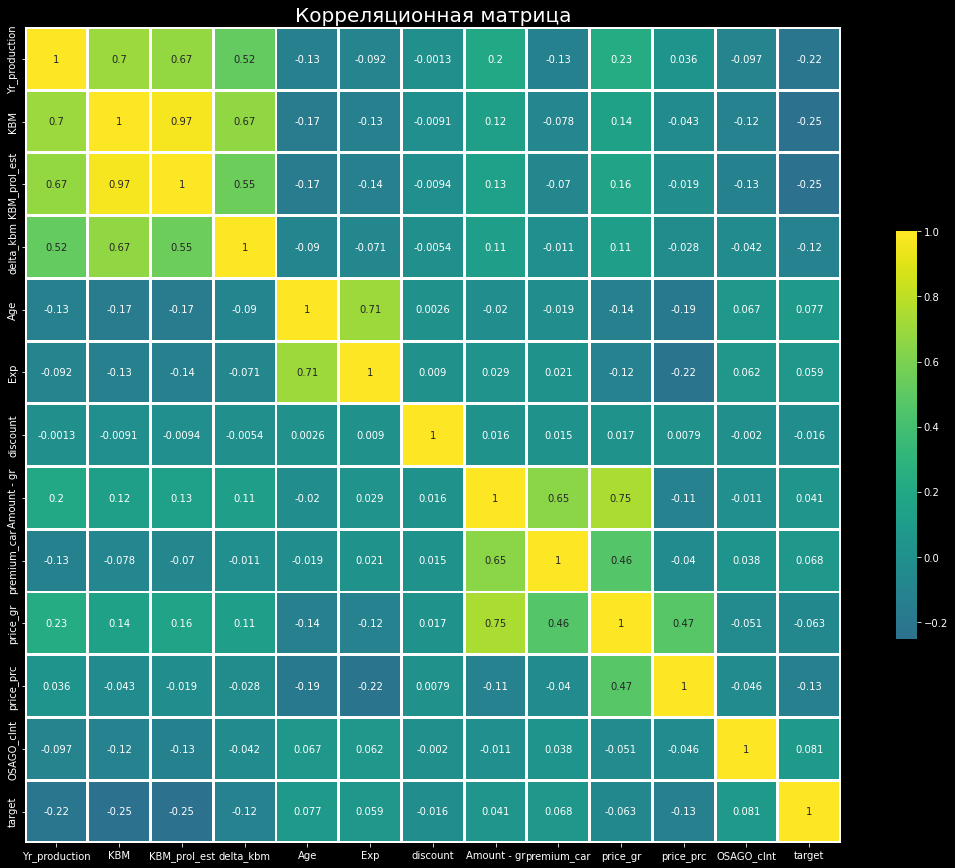

In [21]:
plt.subplots(figsize=(20, 15))
plt.title('Корреляционная матрица', fontsize = 20)
sns.heatmap(train.corr(), vmax=1, annot=True, cmap = 'viridis', linewidths=2, square=True, center=0, cbar_kws={'shrink': .5});

In [22]:
train.corrwith(train['target']).to_frame().sort_values(0).rename(columns={0:'Корреляция с таргетом'})

,Корреляция с таргетом
KBM_prol_est,-0.252639
KBM,-0.252590
Yr_production,-0.216917
price_prc,-0.132684
delta_kbm,-0.123162
price_gr,-0.062880
discount,-0.015798
Amount - gr,0.041422
Exp,0.058507
premium_car,0.068170


In [23]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [24]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['Yr_production', 'KBM', 'KBM_prol_est', 'delta_kbm', 'Age', 'Exp', 'discount', 'Amount - gr', 'premium_car', 'price_gr', 'price_prc', 'OSAGO_clnt', 'target']


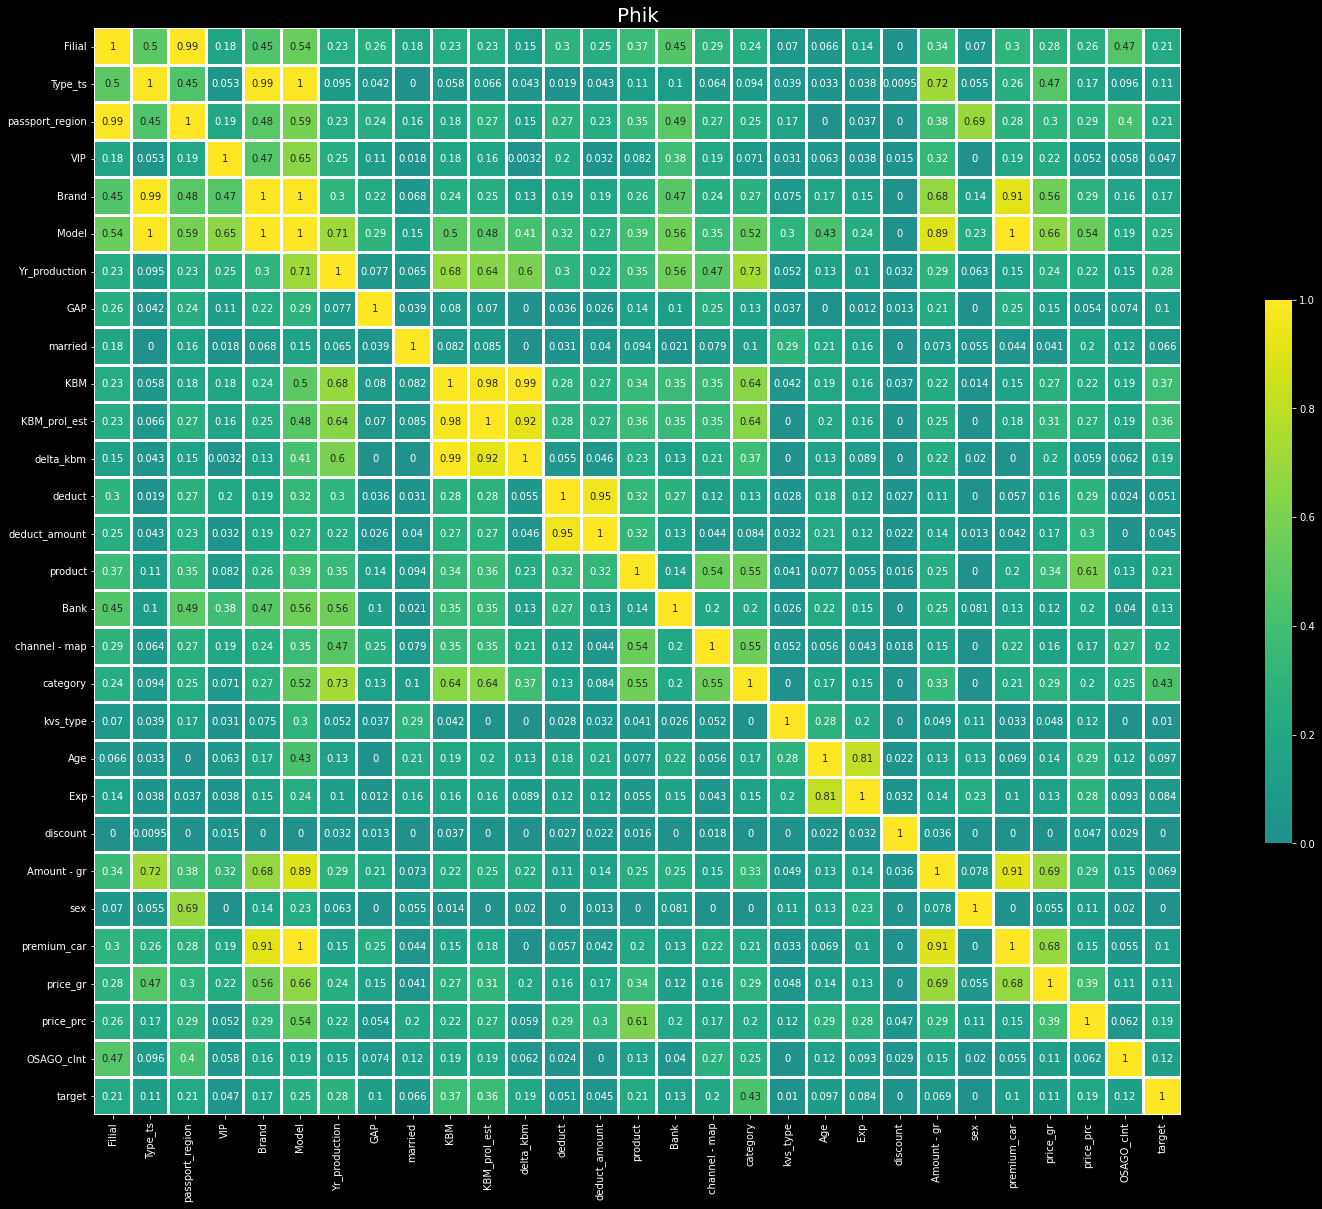

In [25]:
plt.subplots(figsize=(30, 20))
plt.title('Phik', fontsize = 20)
sns.heatmap(phik_overview, vmax=1, annot=True, cmap = 'viridis', linewidths=2, square=True, center=0, cbar_kws={'shrink': .5});

In [26]:
phik_overview['target'].sort_values(ascending=False).to_frame()

,target
target,1.000000
category,0.432043
KBM,0.367257
KBM_prol_est,0.363190
Yr_production,0.280000
Model,0.254618
product,0.214449
passport_region,0.206313
Filial,0.205167
channel - map,0.195362


### Проверяем есть ли связь

**category**

In [27]:
train.groupby('category')['target'].agg(['count', 'mean']) #имеется линейная зависимиость с типом бизнеса

,count,mean
category,,
NB 0-1,4211,0.200665
NB 2+,343,0.215743
RN,2632,0.469225
RN sppg,390,0.523077


**KBM**

In [28]:
train.groupby('KBM')['target'].agg(['count', 'mean']) #не особо понятно

,count,mean
KBM,,
0,243,0.625514
1,41,0.682927
2,132,0.606061
3,37,0.864865
4,424,0.450472
5,97,0.515464
6,928,0.491379
7,140,0.471429
8,5518,0.235049


In [29]:
train['KBM_group'] = pd.cut(train['KBM'], 4)
train.groupby('KBM_group')['target'].agg(['count', 'mean'])

#имеется линейная зависимиость с коэффициентом бонус-малус, мб 8 наблюдений в расчет не берем

,count,mean
KBM_group,,
"(-0.012, 3.0]",453,0.644592
"(3.0, 6.0]",1449,0.481021
"(6.0, 9.0]",5666,0.241264
"(9.0, 12.0]",8,0.250000


**KBM_prol_est**

In [30]:
train.groupby('KBM_prol_est')['target'].agg(['count', 'mean'])

,count,mean
KBM_prol_est,,
0,413,0.624697
1,38,0.842105
2,403,0.444169
3,113,0.522124
4,893,0.491601
5,165,0.466667
6,5231,0.236666
7,270,0.218519
8,16,0.437500


In [31]:
train['KBM_prol_est_group'] = pd.cut(train['KBM_prol_est'], 5)
train.groupby('KBM_prol_est_group')['target'].agg(['count', 'mean'])

#имеется линейная зависимиость, мб 34 наблюдения в расчет не берем

,count,mean
KBM_prol_est_group,,
"(-0.01, 2.0]",854,0.549180
"(2.0, 4.0]",1006,0.495030
"(4.0, 6.0]",5396,0.243699
"(6.0, 8.0]",286,0.230769
"(8.0, 10.0]",34,0.294118


**Yr_production**

In [32]:
train.groupby('Yr_production')['target'].agg(['count', 'mean'])

,count,mean
Yr_production,,
2009,8,0.500000
2010,32,0.593750
2011,54,0.518519
2012,107,0.560748
2013,177,0.576271
2014,297,0.457912
2015,312,0.496795
2016,950,0.326316
2017,1795,0.447354


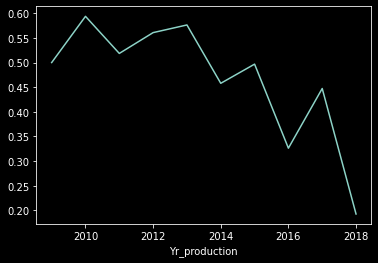

In [33]:
train.groupby('Yr_production')['target'].agg(['count', 'mean'])['mean'].plot(kind='line');

#чем новее ТС, тем меньше вероятность пролонгации

**Model**

In [34]:
t = train.groupby('Model')['target'].agg(['count', 'mean']).sort_values('count', ascending=False).reset_index()
t.head(10)

,Model,count,mean
0,RIO,656,0.251524
1,GRANTA,494,0.228745
2,SOLARIS,447,0.237136
3,VESTA,434,0.237327
4,CRETA,380,0.315789
5,TIGUAN,272,0.419118
6,POLO,269,0.249071
7,SPORTAGE,223,0.322870
8,RAV 4,205,0.326829
9,LARGUS,179,0.268156


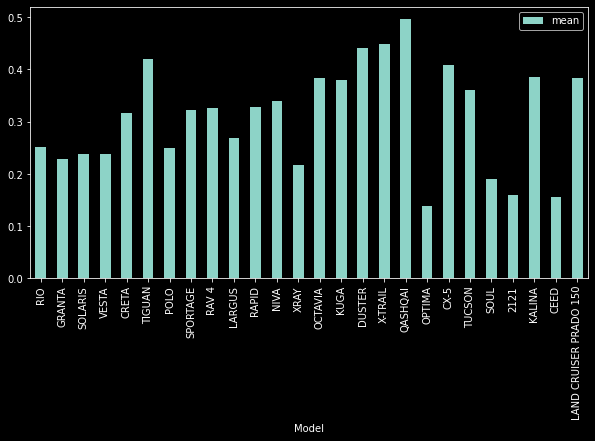

In [35]:
t[t['count'] > 90].plot(kind='bar', x='Model', y='mean', figsize=(10, 5));

**Brand**

In [36]:
train.groupby('Brand')['target'].agg(['count', 'mean']).sort_values('count', ascending=False)

,count,mean
Brand,,
LADA,1511,0.241562
KIA,1330,0.245113
HYUNDAI,1069,0.291862
VOLKSWAGEN,638,0.333856
TOYOTA,451,0.317073
SKODA,385,0.379221
NISSAN,376,0.454787
RENAULT,346,0.367052
FORD,303,0.366337


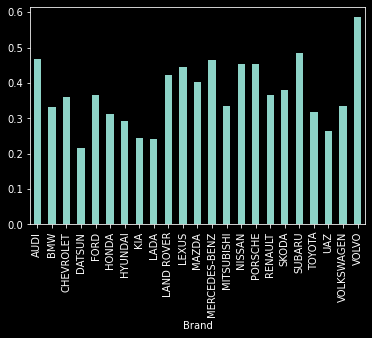

In [37]:
train.groupby('Brand')['target'].agg(['count', 'mean'])['mean'].plot(kind='bar');
#выделется премиум сегмент MERCEDES, LEXUS, AUDI, исключение БМВ. PORSCHE, VOLVO, LAND ROVER маловато наблюдений
#неожиданно SUBARU но тоже мало наюлюдений, NISSAN выделяется из непримеальных марок 

In [38]:
t = train.groupby(['Brand', 'Model'])['target'].agg(['count', 'mean']).sort_values('count', ascending=False).reset_index()
t.head(10)

,Brand,Model,count,mean
0,KIA,RIO,656,0.251524
1,LADA,GRANTA,494,0.228745
2,HYUNDAI,SOLARIS,447,0.237136
3,LADA,VESTA,434,0.237327
4,HYUNDAI,CRETA,380,0.315789
5,VOLKSWAGEN,TIGUAN,272,0.419118
6,VOLKSWAGEN,POLO,269,0.249071
7,KIA,SPORTAGE,223,0.322870
8,TOYOTA,RAV 4,205,0.326829
9,LADA,LARGUS,179,0.268156


In [39]:
t = t.query("Brand in ('AUDI','MERCEDES-BENZ', 'LEXUS', 'NISSAN')")
t.head(10)

,Brand,Model,count,mean
16,NISSAN,X-TRAIL,129,0.449612
17,NISSAN,QASHQAI,119,0.495798
38,NISSAN,TERRANO,46,0.282609
42,AUDI,Q5,33,0.484848
45,LEXUS,NX,31,0.419355
49,NISSAN,ALMERA,29,0.241379
50,LEXUS,RX,29,0.586207
51,NISSAN,JUKE,26,0.692308
55,MERCEDES-BENZ,GLC,22,0.500000
57,MERCEDES-BENZ,GLE,19,0.578947


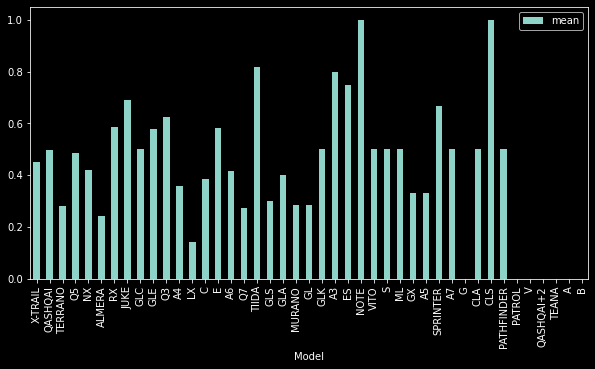

In [40]:
t.plot(kind='bar', x='Model', y='mean', figsize=(10, 5));

In [41]:
# избавляемся от мультиндекса
# t.columns = ['_'.join(col).strip() for col in t.columns.values]

**product**

In [42]:
train.groupby('product')['target'].agg(['count', 'mean']) #линейная зависимость

,count,mean
product,,
Legacy,188,0.000000
Классика,5364,0.302386
Компакт,1581,0.327641
Уверенный,443,0.492099


**passport_region**

In [43]:
train.groupby('passport_region')['target'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)

,count,mean
passport_region,,
Москва,1118,0.409660
Московская область,810,0.350617
Краснодарский край,615,0.177236
Санкт-Петербург,507,0.416174
Ростовская область,382,0.290576
Челябинская область,341,0.252199
Республика Татарстан,295,0.196610
Республика Башкортостан,288,0.197917
Самарская область,284,0.369718


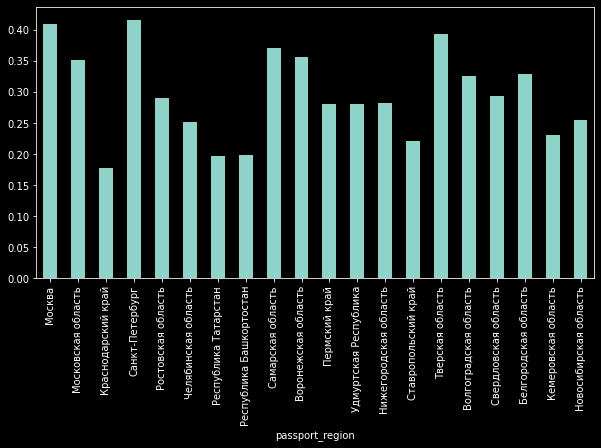

In [44]:
train.groupby('passport_region')['target'].agg(['count', 'mean']).sort_values('count', ascending=False)['mean'].head(20).plot(kind='bar', figsize=(10, 5));

**Filial**

In [45]:
train.groupby('Filial')['target'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)

,count,mean
Filial,,
Московский,2301,0.372012
Краснодарский,763,0.170380
Санкт - Петербургский,736,0.389946
Ростовский,384,0.273438
Воронежский,340,0.344118
Казанский,303,0.194719
Самарский,288,0.357639
Магнитогорский,244,0.176230
Пермский,233,0.291845


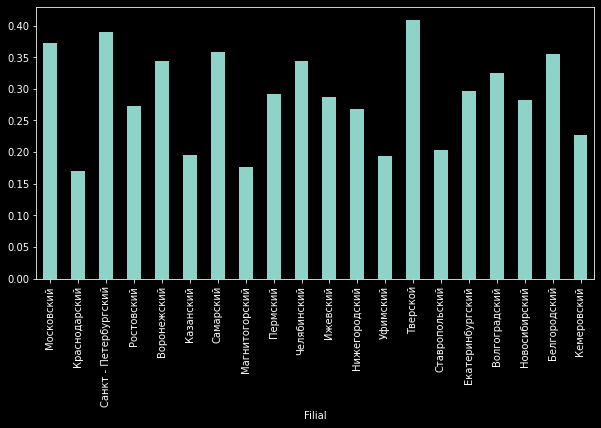

In [46]:
train.groupby('Filial')['target'].agg(['count', 'mean']).sort_values('count', ascending=False)['mean'].head(20).plot(kind='bar', figsize=(10, 5));

**channel - map**

In [47]:
train.groupby('channel - map')['target'].agg(['count', 'mean'])

,count,mean
channel - map,,
Автосалоны,5869,0.279775
Розница,1707,0.419449


**delta_kbm**

In [48]:
train.groupby('delta_kbm')['target'].agg(['count', 'mean'])

,count,mean
delta_kbm,,
-100,243,0.625514
-2,6905,0.298335
-1,380,0.336842
0,10,0.400000
1,33,0.393939
2,5,0.200000


In [49]:
train['delta_kbm_group'] = pd.cut(train['delta_kbm'], 2)
train.groupby('delta_kbm_group')['target'].agg(['count', 'mean'])

,count,mean
delta_kbm_group,,
"(-100.102, -49.0]",243,0.625514
"(-49.0, 2.0]",7333,0.300832


**VIP**

In [50]:
train.groupby('VIP')['target'].agg(['count', 'mean'])

,count,mean
VIP,,
Особый статус,54,0.592593
Особый статус +,151,0.503311
Отсутствует,7371,0.305250


**Exp**

In [51]:
train.groupby('Exp')['target'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10)

,count,mean
Exp,,
10,433,0.267898
18,388,0.296392
11,375,0.338667
17,340,0.311765
9,323,0.275542
12,318,0.276730
13,311,0.337621
15,308,0.327922
16,305,0.314754


In [52]:
train['Exp_group'] = pd.cut(train['Exp'], [-float('inf'), 12, 24, 36, 48, float('inf')])
train.groupby('Exp_group')['target'].agg(['count', 'mean']) #чем больше стаж тем больтше веротяноть пролонгация
#получается one hot encoding делать не нужно, чем больше число тем лучше, наверно

,count,mean
Exp_group,,
"(-inf, 12.0]",2776,0.278818
"(12.0, 24.0]",3340,0.321856
"(24.0, 36.0]",1053,0.335233
"(36.0, 48.0]",388,0.371134
"(48.0, inf]",19,0.631579


**price_gr**

In [53]:
train.groupby('price_gr')['target'].agg(['count', 'mean'])

,count,mean
price_gr,,
10000,1522,0.341656
15000,703,0.375533
20000,671,0.344262
25000,723,0.320885
30000,669,0.340807
35000,619,0.269790
40000,485,0.247423
45000,375,0.250667
50000,348,0.247126


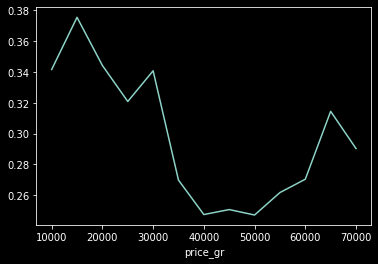

In [54]:
train.groupby('price_gr')['target'].agg(['count', 'mean'])['mean'].plot();

In [55]:
train['price_gr_group'] = pd.qcut(train['price_gr'], 4, duplicates='drop')
train.groupby('price_gr_group')['target'].agg(['count', 'mean'])

,count,mean
price_gr_group,,
"(9999.999, 15000.0]",2225,0.352360
"(15000.0, 30000.0]",2063,0.334949
"(30000.0, 45000.0]",1479,0.257606
"(45000.0, 70000.0]",1809,0.277501


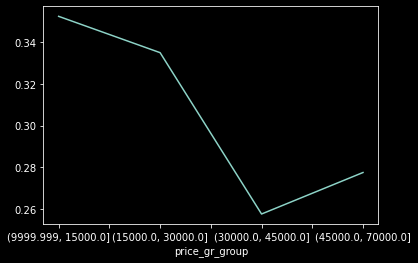

In [56]:
train.groupby('price_gr_group')['target'].agg(['count', 'mean'])['mean'].plot();

**price_prc**

In [57]:
train.groupby('price_prc')['target'].agg(['count', 'mean'])

,count,mean
price_prc,,
0.000,17,0.411765
0.005,163,0.300613
0.010,435,0.358621
0.015,639,0.377152
0.020,949,0.396207
0.025,948,0.376582
0.030,973,0.328880
0.035,843,0.298932
0.040,712,0.289326


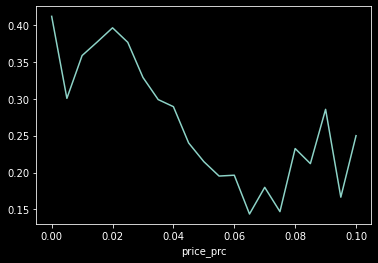

In [58]:
train.groupby('price_prc')['target'].agg(['count', 'mean'])['mean'].plot();

In [59]:
train['price_prc_group'] = pd.qcut(train['price_prc'], 6)
train.groupby('price_prc_group')['target'].agg(['count', 'mean'])
#чем больше премия к сумме покрытия, тем меньше вероятность пролонгирования

,count,mean
price_prc_group,,
"(-0.001, 0.02]",2203,0.376305
"(0.02, 0.025]",948,0.376582
"(0.025, 0.03]",973,0.328880
"(0.03, 0.04]",1555,0.294534
"(0.04, 0.05]",927,0.228695
"(0.05, 0.1]",970,0.187629


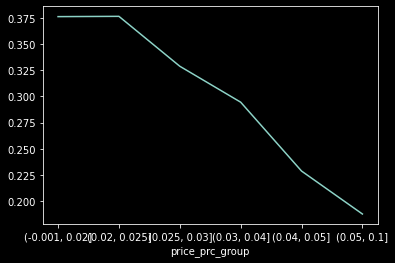

In [60]:
train.groupby('price_prc_group')['target'].agg(['count', 'mean'])['mean'].plot();

**GAP**

In [61]:
train.groupby('GAP')['target'].agg(['count', 'mean'])

,count,mean
GAP,,
Да,776,0.402062
Нет,6800,0.300882


**Type_ts**

In [62]:
train.groupby('Type_ts')['target'].agg(['count', 'mean'])

,count,mean
Type_ts,,
Иностранные,5824,0.329155
Отечественные,1752,0.251712


**married**

In [63]:
train.groupby('married')['target'].agg(['count', 'mean'])

,count,mean
married,,
Не состоит в браке,1643,0.272672
Состоит в браке,5933,0.321928


**deduct**

In [64]:
train.groupby('deduct')['target'].agg(['count', 'mean'])

,count,mean
deduct,,
Без франшизы,5006,0.336596
Безусловная франшиза,1857,0.242865
Франшиза 2-ой страховой случай,713,0.311360


**deduct_amount**

In [65]:
train.groupby('deduct_amount')['target'].agg(['count', 'mean'])

,count,mean
deduct_amount,,
0,5006,0.336596
20000+,1179,0.254453
20000-,1391,0.268152


**Bank**

In [66]:
train.groupby('Bank')['target'].agg(['count', 'mean'])

,count,mean
Bank,,
Банк,4044,0.249505
Без банка,2391,0.452949
Сетелем,1141,0.233129


**kvs_type**

In [67]:
train.groupby('kvs_type')['target'].agg(['count', 'mean'])

,count,mean
kvs_type,,
Водители согласно перечню,7502,0.311917
"Ограничение по стажу и возрасту, без ограничения количества лиц",74,0.243243


**sex**

In [68]:
train.groupby('sex')['target'].agg(['count', 'mean'])

,count,mean
sex,,
,4,0.250000
F,2564,0.318253
M,5008,0.307708


In [69]:
# пол лучше всего коррелирует с passport_region
df['sex'].unique()

array(['M', 'F', ' '], dtype=object)

In [70]:
df[df['passport_region'] == 'н.д.']['sex'].value_counts(normalize=True)

     0.416667
M    0.416667
F    0.166667
Name: sex, dtype: float64

In [71]:
df['sex'].replace(' ', 'M', inplace=True)

In [72]:
df['sex'].value_counts()

M    7164
F    3664
Name: sex, dtype: int64

### Нормализация

In [73]:
df.select_dtypes(np.number).head(5)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
ID,,,,,,,,,,,,,
1,2018,8,6,-2,42,24,1.00,1400000,0,55000,0.040,0,0
2,2016,8,6,-2,41,4,1.05,200000,0,10000,0.010,0,0
3,2018,8,6,-2,49,20,0.95,400000,0,30000,0.065,1,1
4,2016,8,6,-2,40,15,1.10,400000,0,10000,0.020,1,0
5,2018,8,6,-2,58,23,1.00,400000,0,10000,0.015,0,0


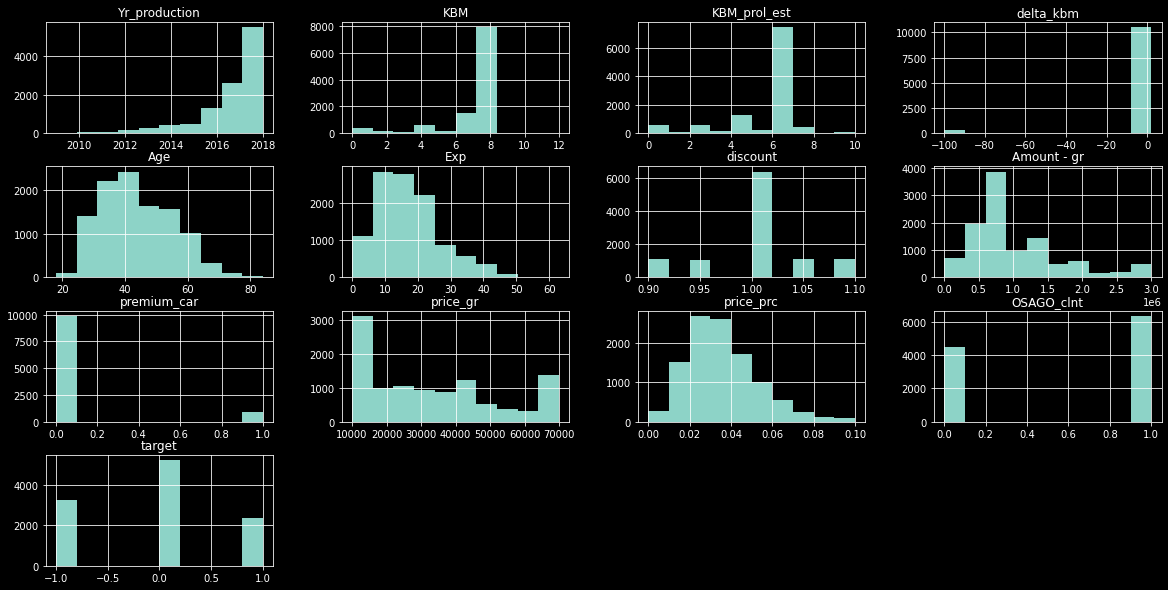

In [74]:
df.select_dtypes(np.number).hist(figsize=(20, 10));

**Логорифмируем**

In [75]:
import pylab 
import scipy.stats as stats

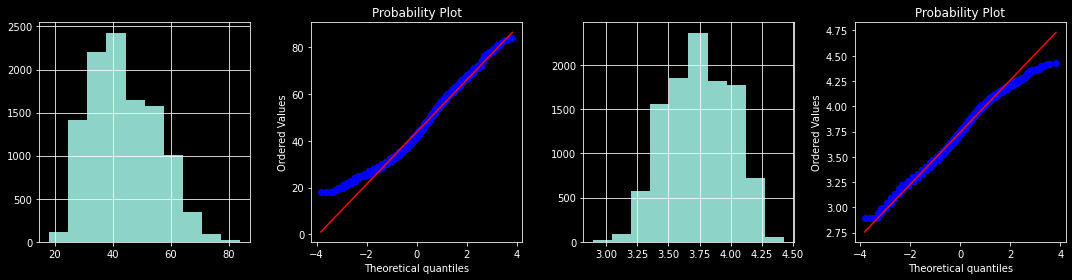

In [76]:
df['Age_log'] = [np.log(i) if i != 0 else i for i in df['Age']]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Age'].hist(ax=axes[0])
stats.probplot(df['Age'], dist="norm", plot=axes[1])
df['Age_log'].hist(ax=axes[2])
stats.probplot(df['Age_log'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

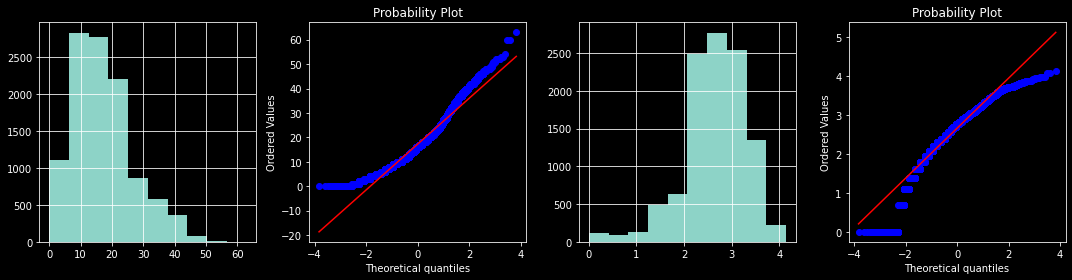

In [77]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Exp_log'] = [np.log(i) if i != 0 else i for i in df['Exp']]

df['Exp'].hist(ax=axes[0])
stats.probplot(df['Exp'], dist="norm", plot=axes[1])
df['Exp_log'].hist(ax=axes[2])
stats.probplot(df['Exp_log'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

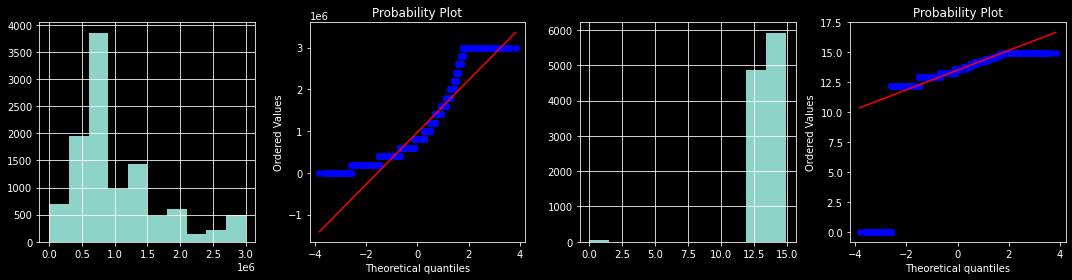

In [78]:
df['Amount - gr_log'] = [np.log(i) if i != 0 else i for i in df['Amount - gr']]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Amount - gr'].hist(ax=axes[0])
stats.probplot(df['Amount - gr'], dist="norm", plot=axes[1])
df['Amount - gr_log'].hist(ax=axes[2])
stats.probplot(df['Amount - gr_log'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

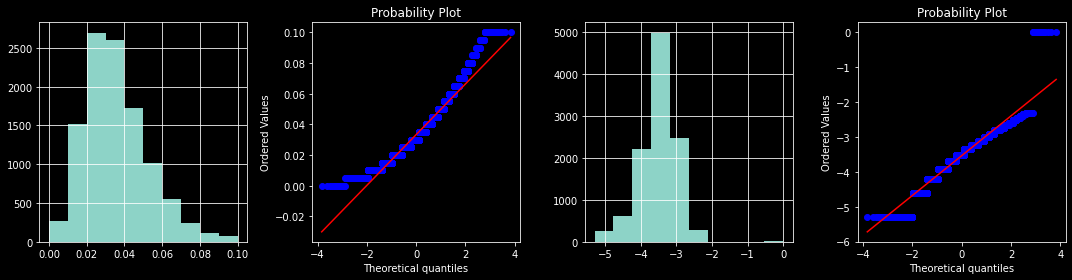

In [79]:
df['price_prc_log'] = [np.log(i) if i != 0 else i for i in df['price_prc']]

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['price_prc'].hist(ax=axes[0])
stats.probplot(df['price_prc'], dist="norm", plot=axes[1])
df['price_prc_log'].hist(ax=axes[2])
stats.probplot(df['price_prc_log'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

**Извлекаем корень**

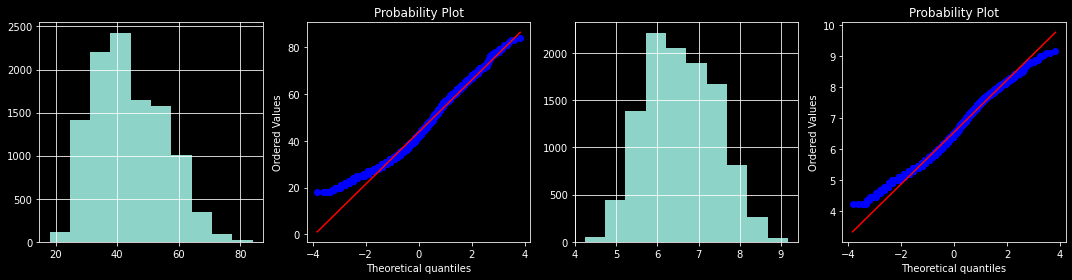

In [80]:
df['Age_sqrt'] = np.sqrt(df['Age'])

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Age'].hist(ax=axes[0])
stats.probplot(df['Age'], dist="norm", plot=axes[1])
df['Age_sqrt'].hist(ax=axes[2])
stats.probplot(df['Age_sqrt'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

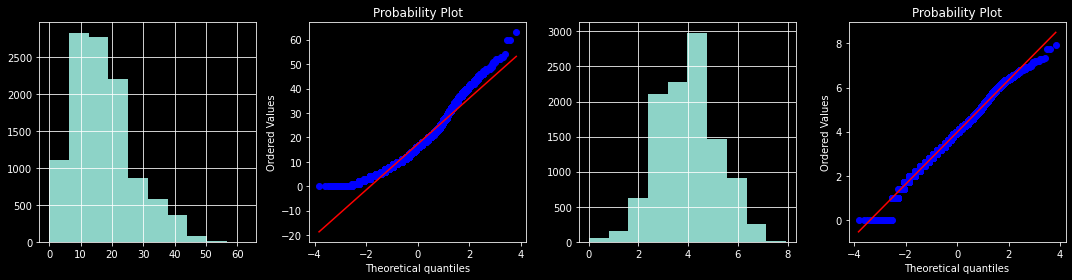

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Exp_sqrt'] = np.sqrt(df['Exp'])

df['Exp'].hist(ax=axes[0])
stats.probplot(df['Exp'], dist="norm", plot=axes[1])
df['Exp_sqrt'].hist(ax=axes[2])
stats.probplot(df['Exp_sqrt'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

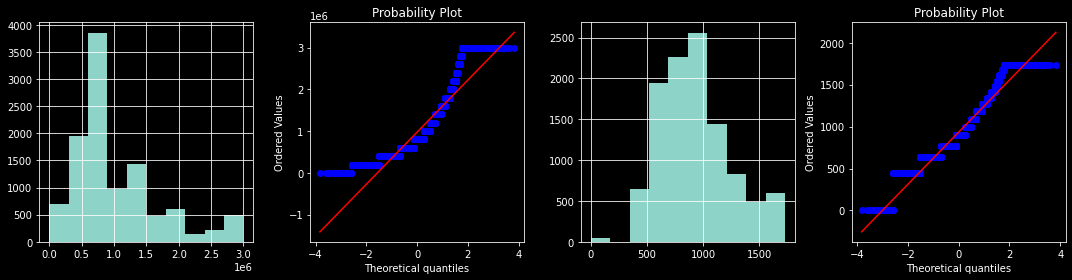

In [82]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['Amount - gr_sqrt'] = np.sqrt(df['Amount - gr'])

df['Amount - gr'].hist(ax=axes[0])
stats.probplot(df['Amount - gr'], dist="norm", plot=axes[1])
df['Amount - gr_sqrt'].hist(ax=axes[2])
stats.probplot(df['Amount - gr_sqrt'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

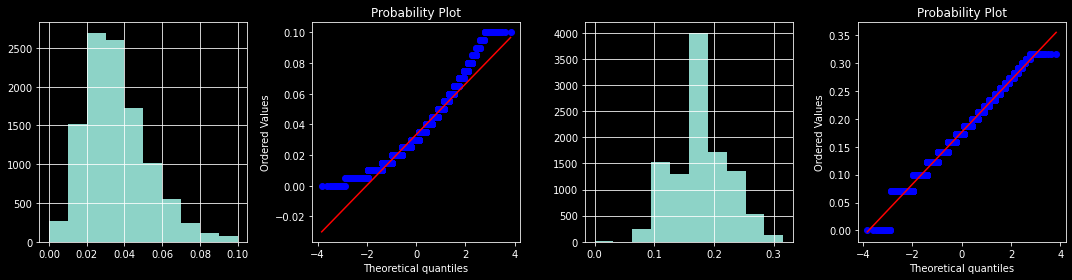

In [83]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

df['price_prc_sqrt'] = np.sqrt(df['price_prc'])

df['price_prc'].hist(ax=axes[0])
stats.probplot(df['price_prc'], dist="norm", plot=axes[1])
df['price_prc_sqrt'].hist(ax=axes[2])
stats.probplot(df['price_prc_sqrt'], dist="norm", plot=axes[3])

plt.tight_layout()
plt.show();

*Извлечение корня лучше нормализует данные*

### Кодируем категориальные фичи, генерируем новые основываясь на проверенных связях.

In [84]:
df.select_dtypes(object).head(3)

,Filial,Type_ts,passport_region,VIP,Brand,Model,GAP,married,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,sex
ID,,,,,,,,,,,,,,,,
1,Магнитогорский,Иностранные,Челябинская область,Отсутствует,TOYOTA,RAV 4,Нет,Состоит в браке,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M
2,Магнитогорский,Отечественные,Челябинская область,Отсутствует,LADA,GRANTA,Нет,Состоит в браке,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,M
3,Ростовский,Отечественные,Ростовская область,Отсутствует,LADA,GRANTA,Нет,Не состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,F


In [85]:
col_num=df.drop('target', axis=1).select_dtypes(np.number).columns.to_list()

In [86]:
df['sex'] = df['sex'].map({'M':1, 'F':0})
df['GAP'] = df['GAP'].map({'Да':1, 'Нет':0})
df['Type_ts'] = df['Type_ts'].map({'Отечественные':1, 'Иностранные':0})
df['married'] = df['married'].map({'Не состоит в браке':1, 'Состоит в браке':0})
df['channel - map'] = df['channel - map'].map({'Автосалоны':1, 'Розница':0})
df['kvs_type'] = df['kvs_type'].map({'Водители согласно перечню':1, 'Ограничение по стажу и возрасту, без ограничения количества лиц':0})

df['product_cast'] = df['product'].map({'Уверенный':3, 'Компакт':2, 'Классика':1, 'Legacy':0})
df['VIP_cast'] = df['VIP'].map({'Особый статус':2, 'Особый статус +':1, 'Отсутствует':0})
df['Bank_cast'] = df['Bank'].map({'Без банка':2, 'Банк':1, 'Сетелем':0})
df['category_cast'] = df['category'].map({'RN sppg':3, 'RN':2, 'NB 2+':1, 'NB 0-1':0})

In [87]:
df['KBM_group'] = pd.cut(df['KBM'], 4).astype(str)
df['KBM_prol_est_group'] = pd.cut(df['KBM_prol_est'], 5).astype(str)
df['delta_kbm_group'] =  pd.cut(df['delta_kbm'], 2).astype(str)
df['Exp_group'] = pd.cut(df['Exp'], [-float('inf'), 12, 24, 36, 48, float('inf')]).astype(str)
df['price_gr_group'] = pd.qcut(df['price_gr'], 4, duplicates='drop').astype(str)
df['price_prc_group'] = pd.qcut(df['price_prc'], 6).astype(str)

In [88]:
df['KBM_cast'] = df['KBM_group'].map({'(-0.012, 3.0]':3, '(3.0, 6.0]':2, '(9.0, 12.0]':1, '(6.0, 9.0]':0})
df['KBM_prol_est_cast'] = df['KBM_prol_est_group'].map({'(-0.01, 2.0]':4, '(2.0, 4.0]':3, '(8.0, 10.0]':2, '(4.0, 6.0]':1, '(6.0, 8.0]':0})
df['Exp_cast'] = df['Exp_group'].map({'(48.0, inf]':4, '(36.0, 48.0]':3, '(24.0, 36.0]':2, '(12.0, 24.0]':1, '(-inf, 12.0]':0})
df['price_gr_cast'] = df['price_gr_group'].map({'(9999.999, 15000.0]':3, '(15000.0, 30000.0]':2, '(30000.0, 45000.0]':1, '(45000.0, 70000.0]':0})
df['price_prc_cast'] = df['price_prc_group'].map({'(-0.001, 0.02]':4, '(0.02, 0.025]':4, '(0.025, 0.03]':3,
                                                  '(0.03, 0.04]':2, '(0.04, 0.05]':1, '(0.05, 0.1]':0})

df['delta_kbm_group'] =  df['delta_kbm_group'].map({'(-100.102, -49.0]':1, '(-49.0, 2.0]':0})

In [89]:
df = pd.get_dummies(data=df, columns=['Filial', 'passport_region', 'Brand', 'Model', 'deduct', 'deduct_amount', 'product', 'VIP', 'Bank',
                                      'category', 'KBM_group', 'KBM_prol_est_group', 'Exp_group', 'price_gr_group', 'price_prc_group'])

In [90]:
df.isna().sum().sum()

0

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10828 entries, 1 to 10863
Columns: 411 entries, Type_ts to price_prc_group_(0.05, 0.1]
dtypes: float64(10), int64(27), uint8(374)
memory usage: 7.0 MB


### Кластеризация, понижение размерности
использую как фичу

In [92]:
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

In [93]:
df_clister = df.drop('target', axis=1).copy()

In [94]:
pca = PCA(n_components=3) 
tsne = TSNE(n_components=3, perplexity=50)
umap = umap.UMAP(n_components=3, n_neighbors=50)

X = RobustScaler().fit_transform(df_clister)

X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


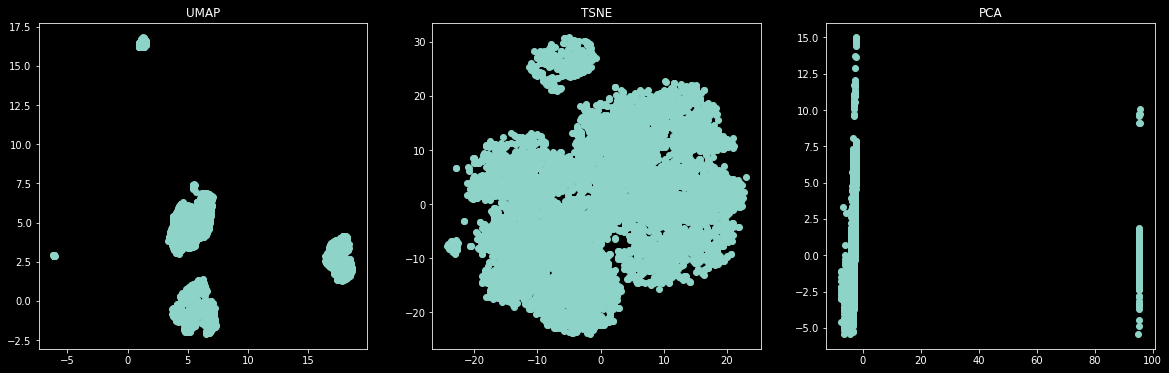

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(X_umap[:, 0], X_umap[:, 1])
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax3.scatter(X_pca[:, 0], X_pca[:, 1])
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

In [96]:
X = {'pca'  : X_pca, 'tsne' : X_tsne, 'umap' : X_umap}
models = {'KMeans' : KMeans(4), 'AggCls' : AgglomerativeClustering(4), 'DBSCAN' : DBSCAN(eps=0.5)}

def plot_results(X: dict, models: dict):
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for i in np.arange(3):
        for j in np.arange(3):
            X_ = list(X.values())[i]
            model = list(models.values())[j].fit(X_)
            colors = model.labels_
            sil_score = silhouette_score(X_, model.labels_)         
            ax[i, j].scatter(X_[:, 0], X_[:, 1], c=colors, cmap='viridis', marker='.', s=10)
            ax[i, j].set_title(f'{list(X.keys())[i]}/{list(models.keys())[j]}: sil_score={sil_score:.3f}')

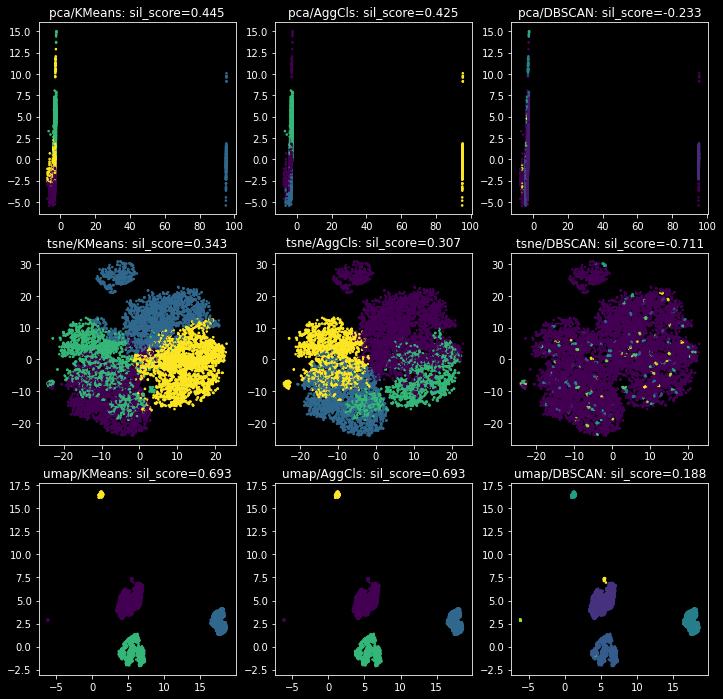

In [97]:
plot_results(X, models)

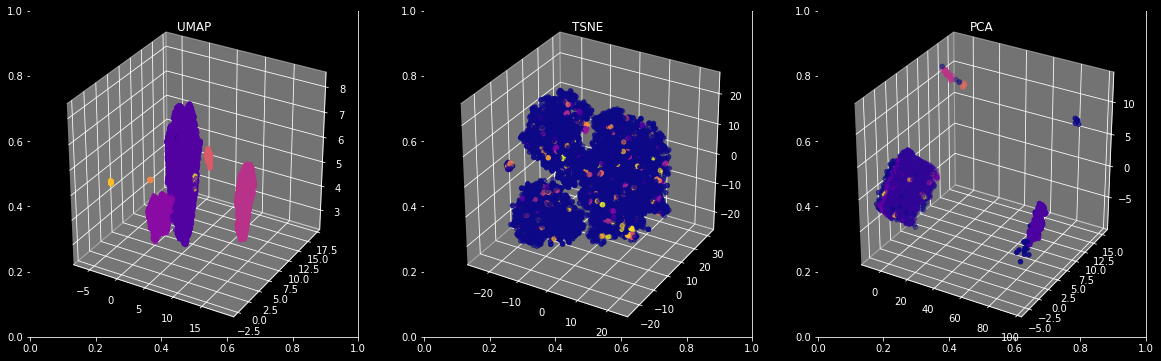

In [98]:
ag = DBSCAN(eps=0.5)
ag_umap = ag.fit_predict(X_umap)
ag_tsne = ag.fit_predict(X_tsne)
ag_pca = ag.fit_predict(X_pca)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')

ax1.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c = ag_umap, cmap='plasma')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = ag_tsne, cmap='plasma')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = ag_pca, cmap='plasma')

ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

In [99]:
df['Cluster'] = ag_tsne
df = pd.concat([df, pd.get_dummies(df['Cluster'], prefix=('Cluster'))], axis=1)
# df.drop('Cluster', axis=1, inplace=True)

### train/valid/test

In [100]:
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import shap 

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

import eli5
from sklearn.feature_selection import RFE

In [101]:
X_train = df[df['target'] != -1].drop('target', axis=1)
X_test = df[df['target'] == -1].drop('target', axis=1)

Y_train = df[df['target'] != -1][['target']]
Y_test = df[df['target'] == -1][['target']]

In [102]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) #stratify=Y_train
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((6060, 570), (1516, 570), (6060, 1), (1516, 1))

In [103]:
sc = StandardScaler()
sc.fit(x_train[col_num])

x_train[col_num] = sc.transform(x_train[col_num])
x_valid[col_num] = sc.transform(x_valid[col_num])
X_test[col_num] = sc.transform(X_test[col_num])

### LogisticRegression, SVC, CatBoostClassifier

In [104]:
model_LR = LogisticRegression(max_iter=10000)
model_LR.fit(x_train, y_train.to_numpy().ravel())

print(classification_report(y_valid, model_LR.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1056
           1       0.58      0.40      0.47       460

    accuracy                           0.73      1516
   macro avg       0.68      0.64      0.64      1516
weighted avg       0.71      0.73      0.71      1516



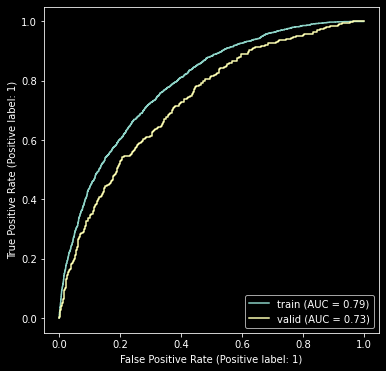

In [105]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_LR.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_LR.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [106]:
model_SVC = SVC(probability=True)
model_SVC.fit(x_train, y_train.to_numpy().ravel())

print(classification_report(y_valid, model_SVC.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82      1056
           1       0.60      0.19      0.29       460

    accuracy                           0.72      1516
   macro avg       0.67      0.57      0.56      1516
weighted avg       0.69      0.72      0.66      1516



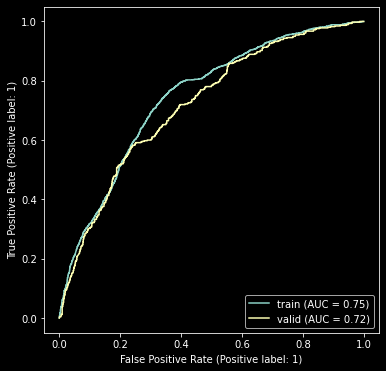

In [107]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_SVC.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_SVC.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [108]:
#params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.001, 0.01, 1]}
params = {'solver': ['sag'], 'C':[0.01]}

grid_search_cv = GridSearchCV(model_LR, params, verbose=False, cv=5, scoring='roc_auc', n_jobs=5)
grid_search_cv.fit(x_train, y_train.to_numpy().ravel())

print(grid_search_cv.best_params_)

{'C': 0.01, 'solver': 'sag'}


In [109]:
model_LR_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_LR_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1056
           1       0.62      0.33      0.43       460

    accuracy                           0.74      1516
   macro avg       0.69      0.62      0.63      1516
weighted avg       0.72      0.74      0.71      1516



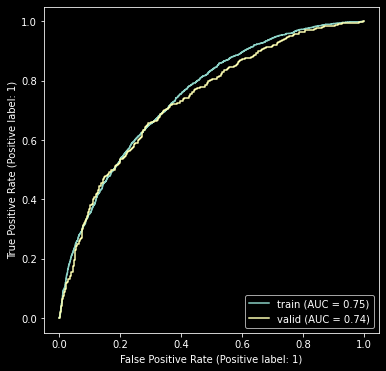

In [110]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_LR_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_LR_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [111]:
eli5.show_weights(model_LR_best, top=10, feature_names = x_train.columns.tolist())

In [112]:
#params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
params = {'C': [100], 'gamma': [0.001],'kernel': ['rbf']}

grid_search_cv = GridSearchCV(model_SVC, params, verbose=False, cv=5, scoring='roc_auc', n_jobs=5)
grid_search_cv.fit(x_train, y_train)

print(grid_search_cv.best_params_)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [113]:
model_SVC_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_SVC_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1056
           1       0.56      0.27      0.36       460

    accuracy                           0.71      1516
   macro avg       0.65      0.59      0.59      1516
weighted avg       0.68      0.71      0.68      1516



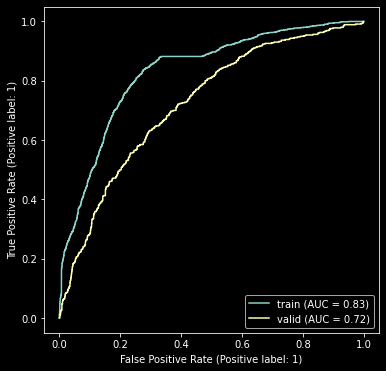

In [114]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_SVC_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_SVC_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [115]:
model_CBC = CatBoostClassifier(learning_rate=0.01, verbose=100, eval_metric='AUC')
model_CBC.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50)

0:	test: 0.6988575	best: 0.6988575 (0)	total: 52.7ms	remaining: 52.6s
100:	test: 0.7383492	best: 0.7383759 (99)	total: 588ms	remaining: 5.24s
200:	test: 0.7441381	best: 0.7441381 (200)	total: 1.14s	remaining: 4.51s
300:	test: 0.7488122	best: 0.7488122 (300)	total: 1.67s	remaining: 3.89s
400:	test: 0.7506279	best: 0.7506279 (400)	total: 2.2s	remaining: 3.28s
500:	test: 0.7525753	best: 0.7525753 (500)	total: 2.75s	remaining: 2.74s
600:	test: 0.7533720	best: 0.7534729 (595)	total: 3.28s	remaining: 2.18s
700:	test: 0.7540349	best: 0.7540349 (700)	total: 3.8s	remaining: 1.62s
800:	test: 0.7549839	best: 0.7550539 (799)	total: 4.33s	remaining: 1.07s
900:	test: 0.7551198	best: 0.7555562 (871)	total: 4.88s	remaining: 536ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7555562418
bestIteration = 871

Shrink model to first 872 iterations.


In [116]:
print(classification_report(y_valid, model_CBC.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1056
           1       0.62      0.35      0.44       460

    accuracy                           0.74      1516
   macro avg       0.69      0.63      0.64      1516
weighted avg       0.72      0.74      0.71      1516



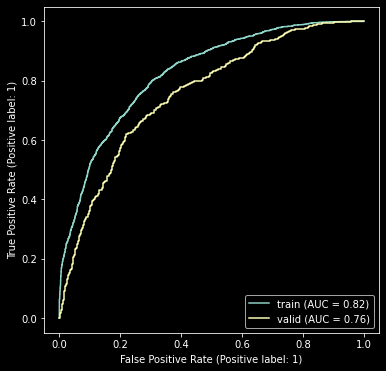

In [117]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_CBC.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_CBC.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [118]:
importances = model_CBC.feature_importances_
final_df = pd.DataFrame({'Признаки' : x_train.columns, 'Важность' : importances})
final_df.sort_values('Важность', ascending=False).head(10)

,Признаки,Важность
26,product_cast,7.598482
1,Yr_production,6.610387
372,product_Legacy,6.286937
28,Bank_cast,6.015186
29,category_cast,4.489319
35,price_prc_cast,2.787195
4,KBM,2.566027
380,Bank_Без банка,2.527217
384,category_RN,2.124270
24,Amount - gr_sqrt,2.116156


In [119]:
params = {'iterations': [500],
          'depth': [1, 3, 5],
          'loss_function': ['Logloss', 'CrossEntropy', 'AUC'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]}
          
grid_search_cv = GridSearchCV(estimator=CatBoostClassifier(), param_grid=params, verbose=False, scoring='roc_auc', cv=5, n_jobs=5)
grid_search_cv.fit(x_train, y_train)

print(grid_search_cv.best_params_)


45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5126, in fit
    CatBoostClassifier._check_is_compatible_loss(params['loss_function'])
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5479, in _check_is_compatible_loss
    "Logloss, CrossEntropy, MultiClass, MultiClassOneVsAll or custom objective object".format(loss_function))
_catboost.CatBoostError: Invalid loss_functi

{'depth': 3, 'iterations': 500, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}


In [120]:
model_CBR_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_CBR_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1056
           1       0.61      0.35      0.44       460

    accuracy                           0.73      1516
   macro avg       0.68      0.63      0.63      1516
weighted avg       0.71      0.73      0.71      1516



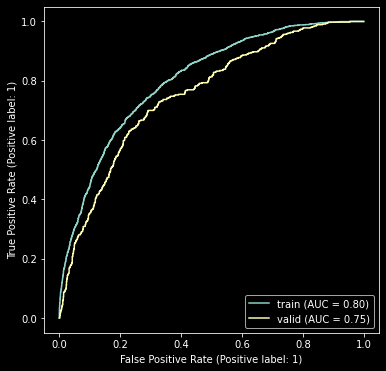

In [121]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_CBR_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_CBR_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [122]:
eli5.show_weights(model_CBR_best, top=10, feature_names = x_train.columns.tolist())

Weight,Feature
0.2343,product_cast
0.0739,product_Legacy
0.0491,Yr_production
0.0403,category_cast
0.0321,Bank_cast
0.0194,KBM_prol_est
0.0170,price_prc_sqrt
0.0163,KBM_cast
0.0155,deduct_Безусловная франшиза
0.0150,Filial_Уфимский


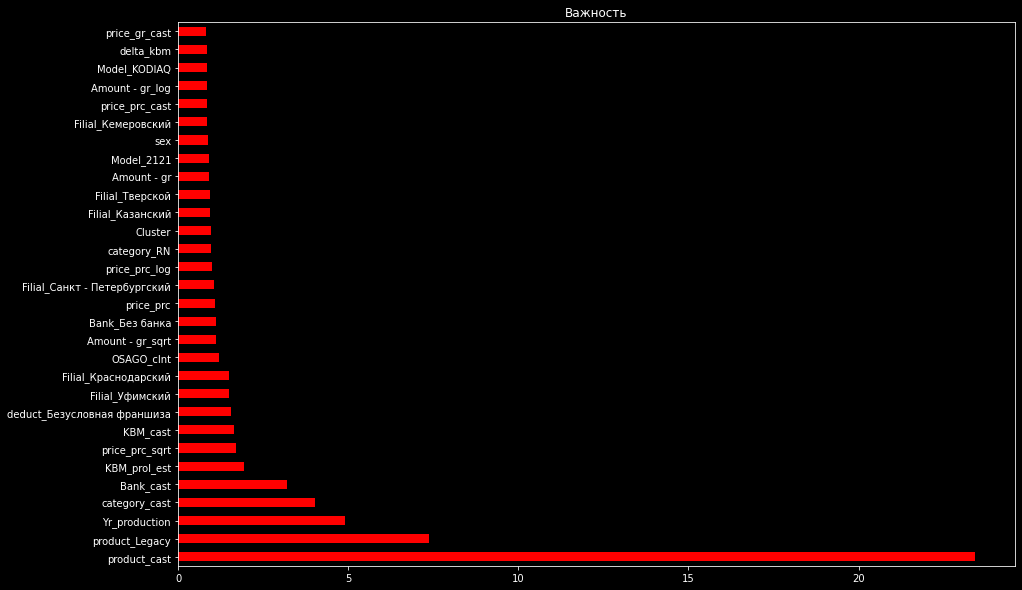

In [123]:
importances = model_CBR_best.feature_importances_
fig, ax = plt.subplots(figsize=(15,10))
feature_importances_cat = pd.Series(importances, index= x_train.columns)
feature_importances_cat.nlargest(30).plot(kind='barh', color='r', align='center')
plt.title('Важность');

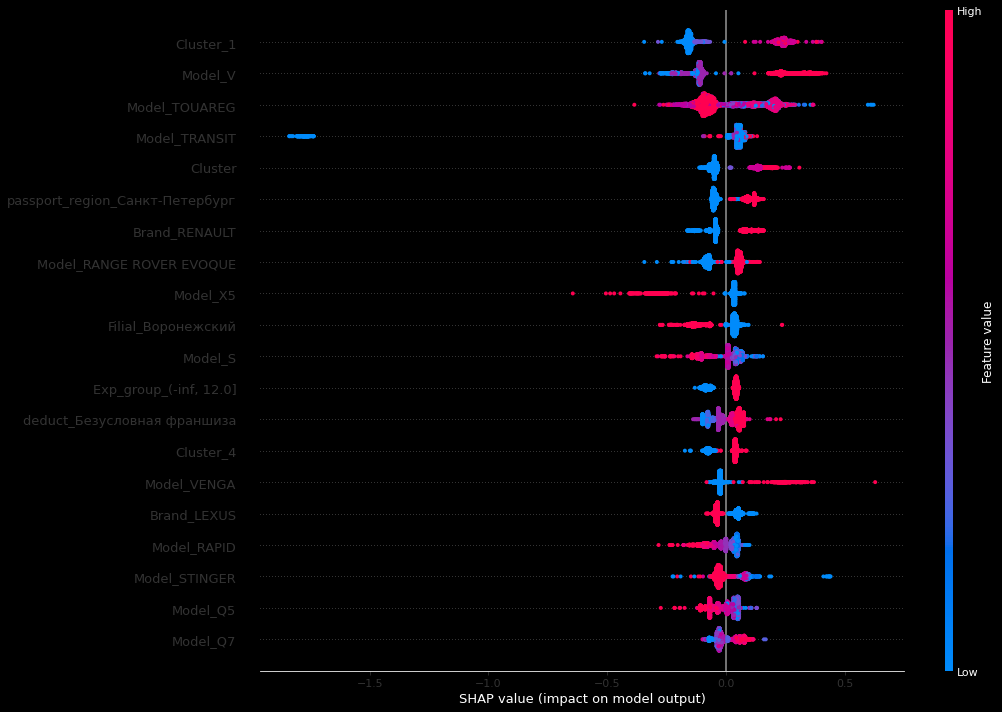

In [124]:
sorted_feature_importance = model_CBR_best.feature_importances_.argsort()
explainer = shap.TreeExplainer(model_CBR_best)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names = df.columns[sorted_feature_importance], plot_size=[15, 10]);

### Сэмплинг

In [125]:
Y_train.value_counts(normalize=True)

target
0         0.688754
1         0.311246
dtype: float64

In [126]:
# print(f'Количество строк в y_train по классам: {np.bincount(y_train)}')
# print(f'Количество строк в y_valid по классам: {np.bincount(y_valid)}')

In [127]:
from imblearn.over_sampling import SMOTE

# бороться с несбалансированностью буду с помощью увеличения числа экземпляров минорного класса. для этого выбран алгоритм smote семплинг
smt = SMOTE()
X_sm, Y_sm = smt.fit_resample(X_train, Y_train)

In [128]:
x_train, x_valid, y_train, y_valid = train_test_split(X_sm, Y_sm, test_size=0.2, random_state=42) #stratify=Y_sm
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((8348, 570), (2088, 570), (8348, 1), (2088, 1))

In [129]:
# print(f'Количество строк в y_train по классам: {np.bincount(y_train)}')
# print(f'Количество строк в y_valid по классам: {np.bincount(y_valid)}')

In [130]:
sc = StandardScaler()
sc.fit(x_train[col_num])

x_train[col_num] = sc.transform(x_train[col_num])
x_valid[col_num] = sc.transform(x_valid[col_num])
X_test[col_num] = sc.transform(X_test[col_num])

### LogisticRegression, SVC, CatBoostClassifier

In [131]:
model_LR = LogisticRegression(max_iter=10000)
model_LR.fit(x_train, y_train.to_numpy().ravel())

print(classification_report(y_valid, model_LR.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1044
           1       0.85      0.72      0.78      1044

    accuracy                           0.80      2088
   macro avg       0.81      0.80      0.80      2088
weighted avg       0.81      0.80      0.80      2088



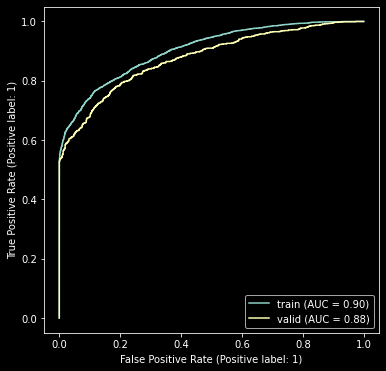

In [132]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_LR.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_LR.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [133]:
model_SVC = SVC(probability=True)
model_SVC.fit(x_train, y_train.to_numpy().ravel())

print(classification_report(y_valid, model_SVC.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1044
           1       0.80      0.72      0.76      1044

    accuracy                           0.77      2088
   macro avg       0.77      0.77      0.77      2088
weighted avg       0.77      0.77      0.77      2088



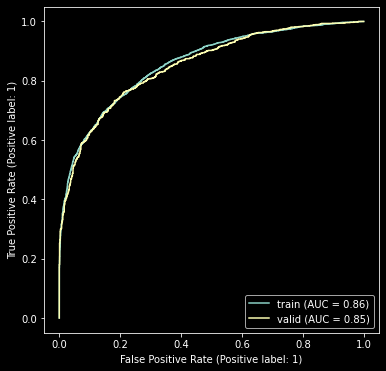

In [134]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_SVC.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_SVC.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [135]:
# params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.01, 1, 5]}
params = {'solver': ['lbfgs'], 'C':[1]}
grid_search_cv = GridSearchCV(model_LR, params, verbose=False, cv=5, scoring='roc_auc', n_jobs=5)
grid_search_cv.fit(x_train, y_train.to_numpy().ravel())

print(grid_search_cv.best_params_)

{'C': 1, 'solver': 'lbfgs'}


In [136]:
model_LR_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_LR_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1044
           1       0.85      0.72      0.78      1044

    accuracy                           0.80      2088
   macro avg       0.81      0.80      0.80      2088
weighted avg       0.81      0.80      0.80      2088



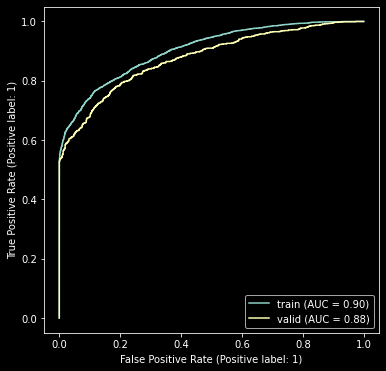

In [137]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_LR_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_LR_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [138]:
eli5.show_weights(model_LR_best, top=10, feature_names = x_train.columns.tolist())

In [139]:
#params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
params = {'C': [100], 'gamma': [0.001],'kernel': ['rbf']}
grid_search_cv = GridSearchCV(model_SVC, params, verbose=False, cv=5, scoring='roc_auc', n_jobs=5)
grid_search_cv.fit(x_train, y_train.to_numpy().ravel())
print(grid_search_cv.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [140]:
model_SVC_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_SVC_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1044
           1       0.88      0.68      0.77      1044

    accuracy                           0.79      2088
   macro avg       0.81      0.79      0.79      2088
weighted avg       0.81      0.79      0.79      2088



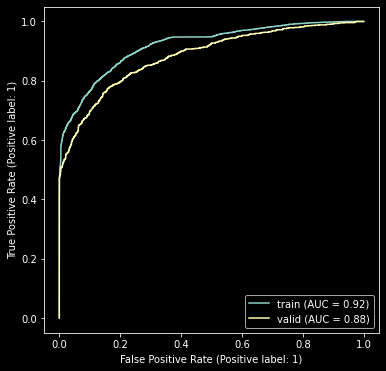

In [141]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_SVC_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_SVC_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [143]:
model_CBC = CatBoostClassifier(learning_rate=0.01, verbose=100, eval_metric='AUC')
model_CBC.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50)

0:	test: 0.8178563	best: 0.8178563 (0)	total: 7.48ms	remaining: 7.47s
100:	test: 0.8602799	best: 0.8603166 (99)	total: 768ms	remaining: 6.84s
200:	test: 0.8663376	best: 0.8663376 (200)	total: 1.51s	remaining: 6s
300:	test: 0.8705869	best: 0.8705869 (300)	total: 2.26s	remaining: 5.24s
400:	test: 0.8731513	best: 0.8731513 (400)	total: 2.98s	remaining: 4.46s
500:	test: 0.8755060	best: 0.8755060 (500)	total: 3.71s	remaining: 3.69s
600:	test: 0.8772272	best: 0.8772501 (598)	total: 4.45s	remaining: 2.96s
700:	test: 0.8785254	best: 0.8785420 (697)	total: 5.16s	remaining: 2.2s
800:	test: 0.8797705	best: 0.8797705 (800)	total: 5.88s	remaining: 1.46s
900:	test: 0.8802136	best: 0.8803577 (883)	total: 6.59s	remaining: 724ms
999:	test: 0.8809540	best: 0.8809806 (996)	total: 7.31s	remaining: 0us

bestTest = 0.8809806264
bestIteration = 996

Shrink model to first 997 iterations.


In [144]:
print(classification_report(y_valid, model_CBC.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1044
           1       0.82      0.75      0.78      1044

    accuracy                           0.79      2088
   macro avg       0.80      0.79      0.79      2088
weighted avg       0.80      0.79      0.79      2088



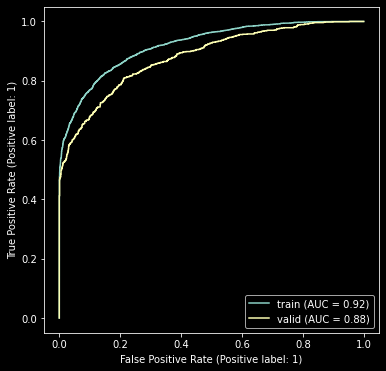

In [145]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_CBC.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_CBC.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [146]:
importances = model_CBC.feature_importances_
final_df = pd.DataFrame({'Признаки' : x_train.columns, 'Важность' : importances})
final_df.sort_values('Важность', ascending=False).head(10)

,Признаки,Важность
379,Bank_Банк,14.984690
11,discount,10.286540
381,Bank_Сетелем,9.871318
28,Bank_cast,6.780848
380,Bank_Без банка,5.107621
382,category_NB 0-1,4.238885
366,deduct_Без франшизы,3.360720
371,deduct_amount_20000-,3.358092
370,deduct_amount_20000+,2.972880
367,deduct_Безусловная франшиза,2.840353


In [147]:
params = {'iterations': [500],
          'depth': [1, 3, 5],
          'loss_function': ['Logloss', 'CrossEntropy', 'AUC'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]}

grid_search_cv = GridSearchCV(estimator=CatBoostClassifier(), param_grid=params, verbose=False, scoring='roc_auc', cv=5, n_jobs=5)
grid_search_cv.fit(x_train, y_train)

print(grid_search_cv.best_params_)


45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5126, in fit
    CatBoostClassifier._check_is_compatible_loss(params['loss_function'])
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5479, in _check_is_compatible_loss
    "Logloss, CrossEntropy, MultiClass, MultiClassOneVsAll or custom objective object".format(loss_function))
_catboost.CatBoostError: Invalid loss_functi

{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}


In [148]:
model_CBR_best = grid_search_cv.best_estimator_
print(classification_report(y_valid, model_CBR_best.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1044
           1       0.81      0.74      0.77      1044

    accuracy                           0.78      2088
   macro avg       0.79      0.78      0.78      2088
weighted avg       0.79      0.78      0.78      2088



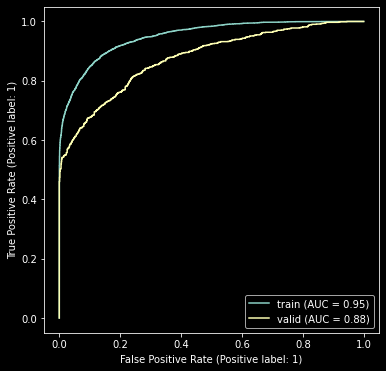

In [149]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, model_CBR_best.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, model_CBR_best.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [150]:
eli5.show_weights(model_CBR_best, top=10, feature_names = x_train.columns.tolist())

Weight,Feature
0.1501,discount
0.1037,Bank_Банк
0.0748,Bank_cast
0.0666,Bank_Сетелем
0.0444,deduct_Без франшизы
0.0291,deduct_Безусловная франшиза
0.0284,price_prc
0.0256,deduct_amount_20000-
0.0244,product_Legacy
0.0221,deduct_amount_20000+


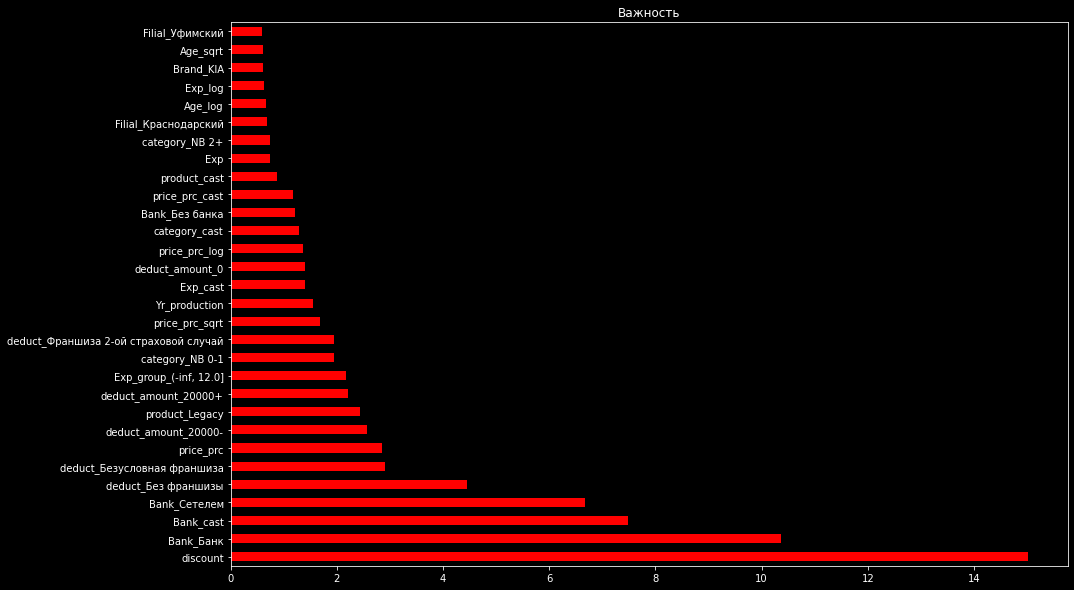

In [151]:
importances = model_CBR_best.feature_importances_
fig, ax = plt.subplots(figsize=(15,10))
feature_importances_cat = pd.Series(importances, index= x_train.columns)
feature_importances_cat.nlargest(30).plot(kind='barh', color='r', align='center')
plt.title('Важность');

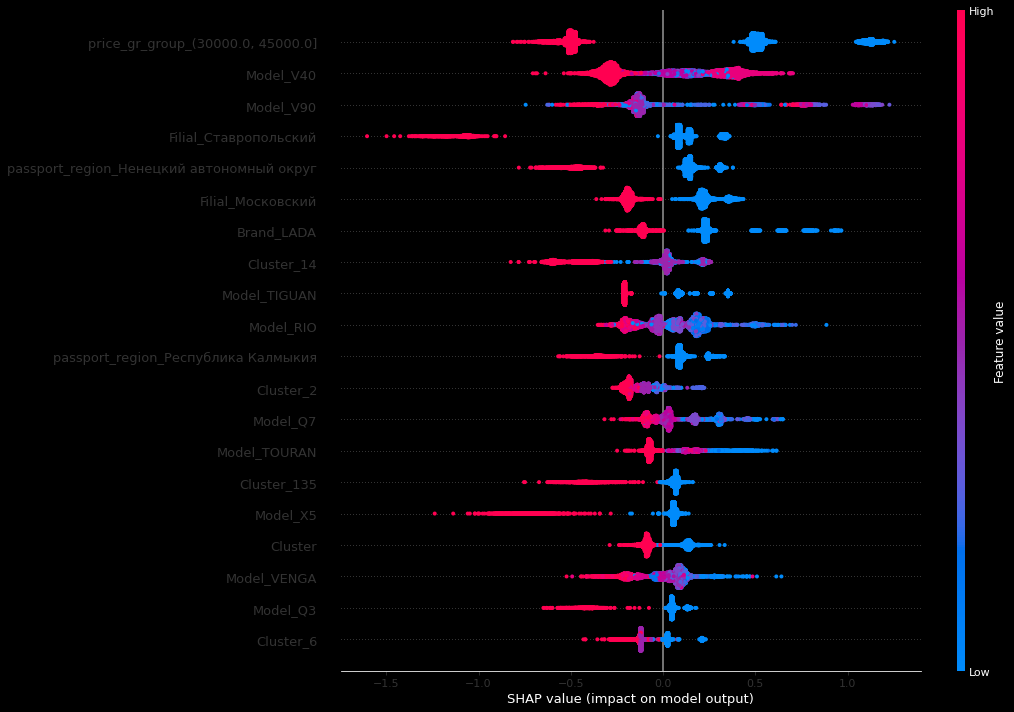

In [152]:
sorted_feature_importance = model_CBR_best.feature_importances_.argsort()
explainer = shap.TreeExplainer(model_CBR_best)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names = df.columns[sorted_feature_importance], plot_size=[15, 10]);

### Отбираем 100 лучших фичей

In [154]:
rfe_LR = RFE(model_LR_best, n_features_to_select=100)
rfe_LR.fit(x_train, y_train.to_numpy().ravel())

RFE(estimator=LogisticRegression(C=1, max_iter=10000), n_features_to_select=100)

In [155]:
print(classification_report(y_valid, rfe_LR.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1044
           1       0.86      0.71      0.77      1044

    accuracy                           0.79      2088
   macro avg       0.80      0.79      0.79      2088
weighted avg       0.80      0.79      0.79      2088



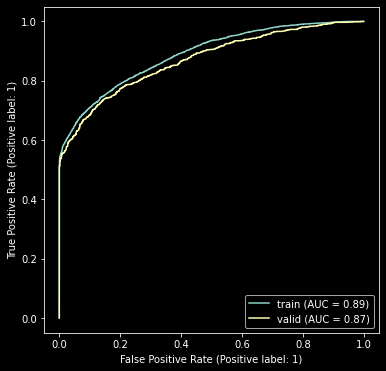

In [156]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, rfe_LR.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, rfe_LR.predict_proba(x_valid)[:, 1],name='valid',ax=ax);

In [ ]:
rfe_CBR = RFE(model_CBR_best, n_features_to_select=100)
rfe_CBR.fit(x_train, y_train)

In [ ]:
print(classification_report(y_valid, rfe_CBR.predict(x_valid)))

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_train, rfe_CBR.predict_proba(x_train)[:, 1],name='train',ax=ax)
RocCurveDisplay.from_predictions(y_valid, rfe_CBR.predict_proba(x_valid)[:, 1],name='valid',ax=ax);